In [1]:
!nvidia-smi

Thu Dec 14 17:16:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'
# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 2.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
torch:  2.1 ; cuda:  cu118
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-nzil8530
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-nzil8530
  Resolved https://github.com/facebookresearch/detectron2.git to commit a0e22dbfa791e6235e4f196d5ce25e754d02be31
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━

In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [5]:
%cd /content/drive/MyDrive/Deep_Learning

/content/drive/MyDrive/Deep_Learning


In [6]:
!pwd

/content/drive/MyDrive/Deep_Learning


In [7]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("sample", {}, "./data/trainval.json", "./data/images")

In [8]:
sample_metadata = MetadataCatalog.get("sample")
dataset_dicts = DatasetCatalog.get("sample")

WARNING [12/14 17:23:03 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/14 17:23:03 d2.data.datasets.coco]: Loaded 51 images in COCO format from ./data/trainval.json


In [9]:
dataset_dicts

[{'file_name': './data/images/01272020-Kawasaki-Ninja-650-4411-633x388.jpg',
  'height': 388,
  'width': 633,
  'image_id': 0,
  'annotations': [{'iscrowd': 0,
    'bbox': [346.0, 8.0, 76.0, 91.0],
    'category_id': 7,
    'segmentation': [[347.2267206477733,
      47.773279352226716,
      347.2267206477733,
      39.67611336032388,
      347.6315789473684,
      33.19838056680162,
      349.251012145749,
      24.2914979757085,
      353.7044534412955,
      16.194331983805668,
      358.56275303643724,
      13.360323886639675,
      368.2793522267206,
      9.7165991902834,
      377.5910931174089,
      8.906882591093117,
      384.8785425101214,
      8.906882591093117,
      394.1902834008097,
      9.7165991902834,
      403.0971659919028,
      13.360323886639675,
      409.17004048582993,
      17.40890688259109,
      415.2429149797571,
      24.2914979757085,
      419.69635627530363,
      31.57894736842105,
      422.5303643724696,
      40.08097165991902,
      422.1255

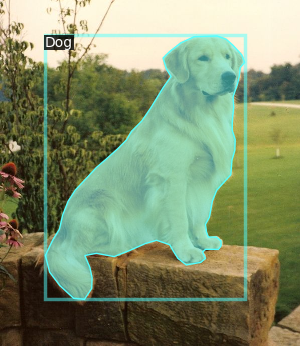

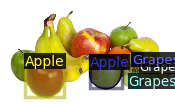

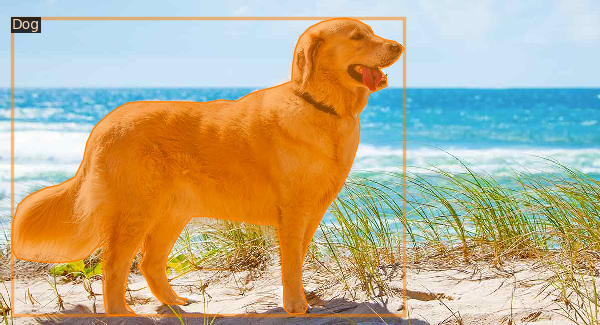

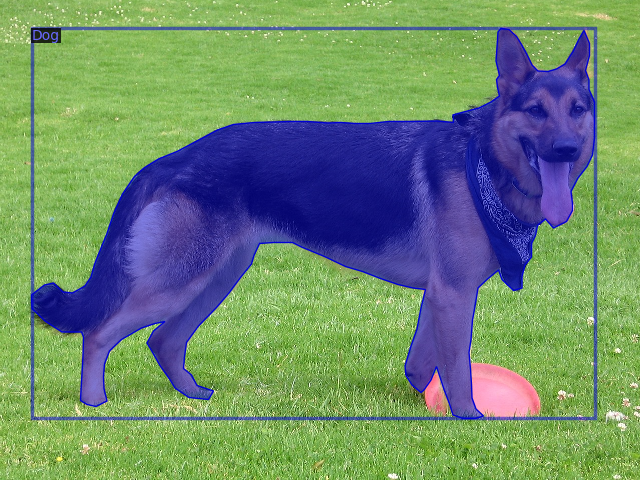

In [11]:
import random

for d in random.sample(dataset_dicts, 4):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=sample_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [12]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("sample",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 14  # (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[12/14 17:29:32 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 175MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[12/14 17:29:34 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/14 17:29:48 d2.utils.events]:  eta: 0:02:07  iter: 19  total_loss: 3.677  loss_cls: 2.469  loss_box_reg: 0.5176  loss_mask: 0.6918  loss_rpn_cls: 0.03141  loss_rpn_loc: 0.01309    time: 0.4630  last_time: 0.5094  data_time: 0.0496  last_data_time: 0.0076   lr: 0.00016068  max_mem: 2673M
[12/14 17:30:01 d2.utils.events]:  eta: 0:02:02  iter: 39  total_loss: 2.347  loss_cls: 0.9401  loss_box_reg: 0.6584  loss_mask: 0.6508  loss_rpn_cls: 0.03375  loss_rpn_loc: 0.0123    time: 0.4875  last_time: 0.4273  data_time: 0.0296  last_data_time: 0.0058   lr: 0.00032718  max_mem: 2673M
[12/14 17:30:11 d2.utils.events]:  eta: 0:01:52  iter: 59  total_loss: 1.809  loss_cls: 0.6455  loss_box_reg: 0.5457  loss_mask: 0.5546  loss_rpn_cls: 0.01087  loss_rpn_loc: 0.007376    time: 0.4851  last_time: 0.4640  data_time: 0.0139  last_data_time: 0.0059   lr: 0.00049367  max_mem: 2673M
[12/14 17:30:20 d2.utils.events]:  eta: 0:01:42  iter: 79  total_loss: 1.766  loss_cls: 0.6572  loss_box_reg: 0.6879  loss

In [13]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("sample", )
predictor = DefaultPredictor(cfg)

[12/14 17:35:51 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


In [14]:
%pwd

'/content/drive/MyDrive/Deep_Learning'

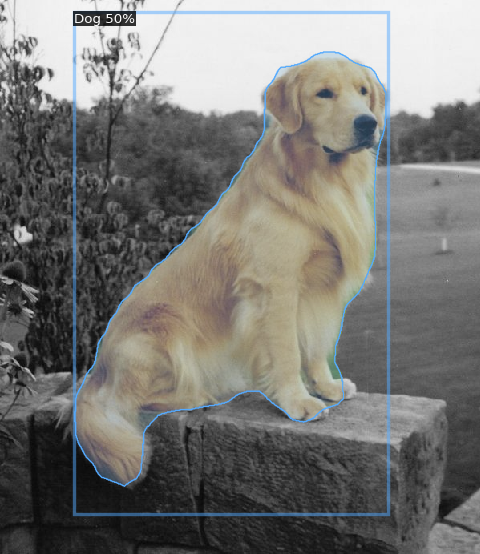

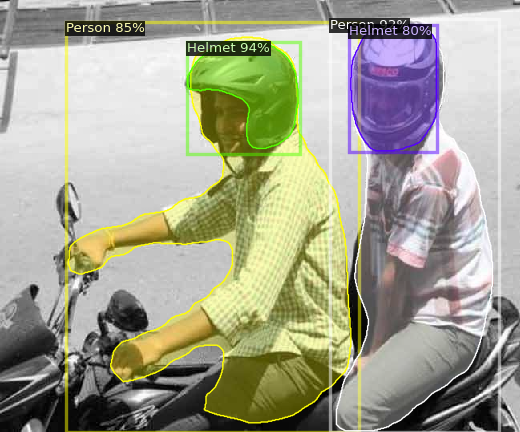

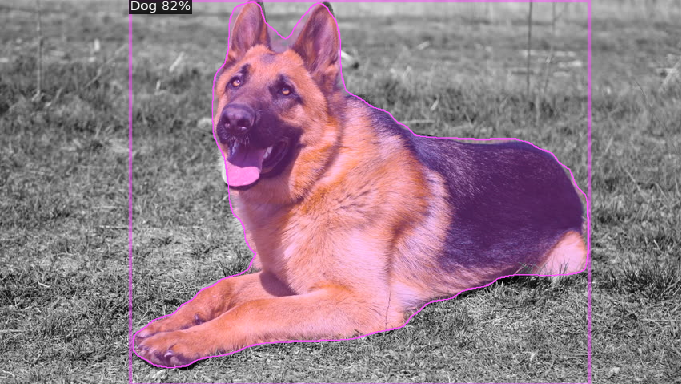

In [15]:
from detectron2.utils.visualizer import ColorMode
import os

data_path = "/content/drive/MyDrive/Deep_Learning/test_data/"

for d in os.listdir("test_data"):
    im = cv2.imread(data_path + d)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=sample_metadata,
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

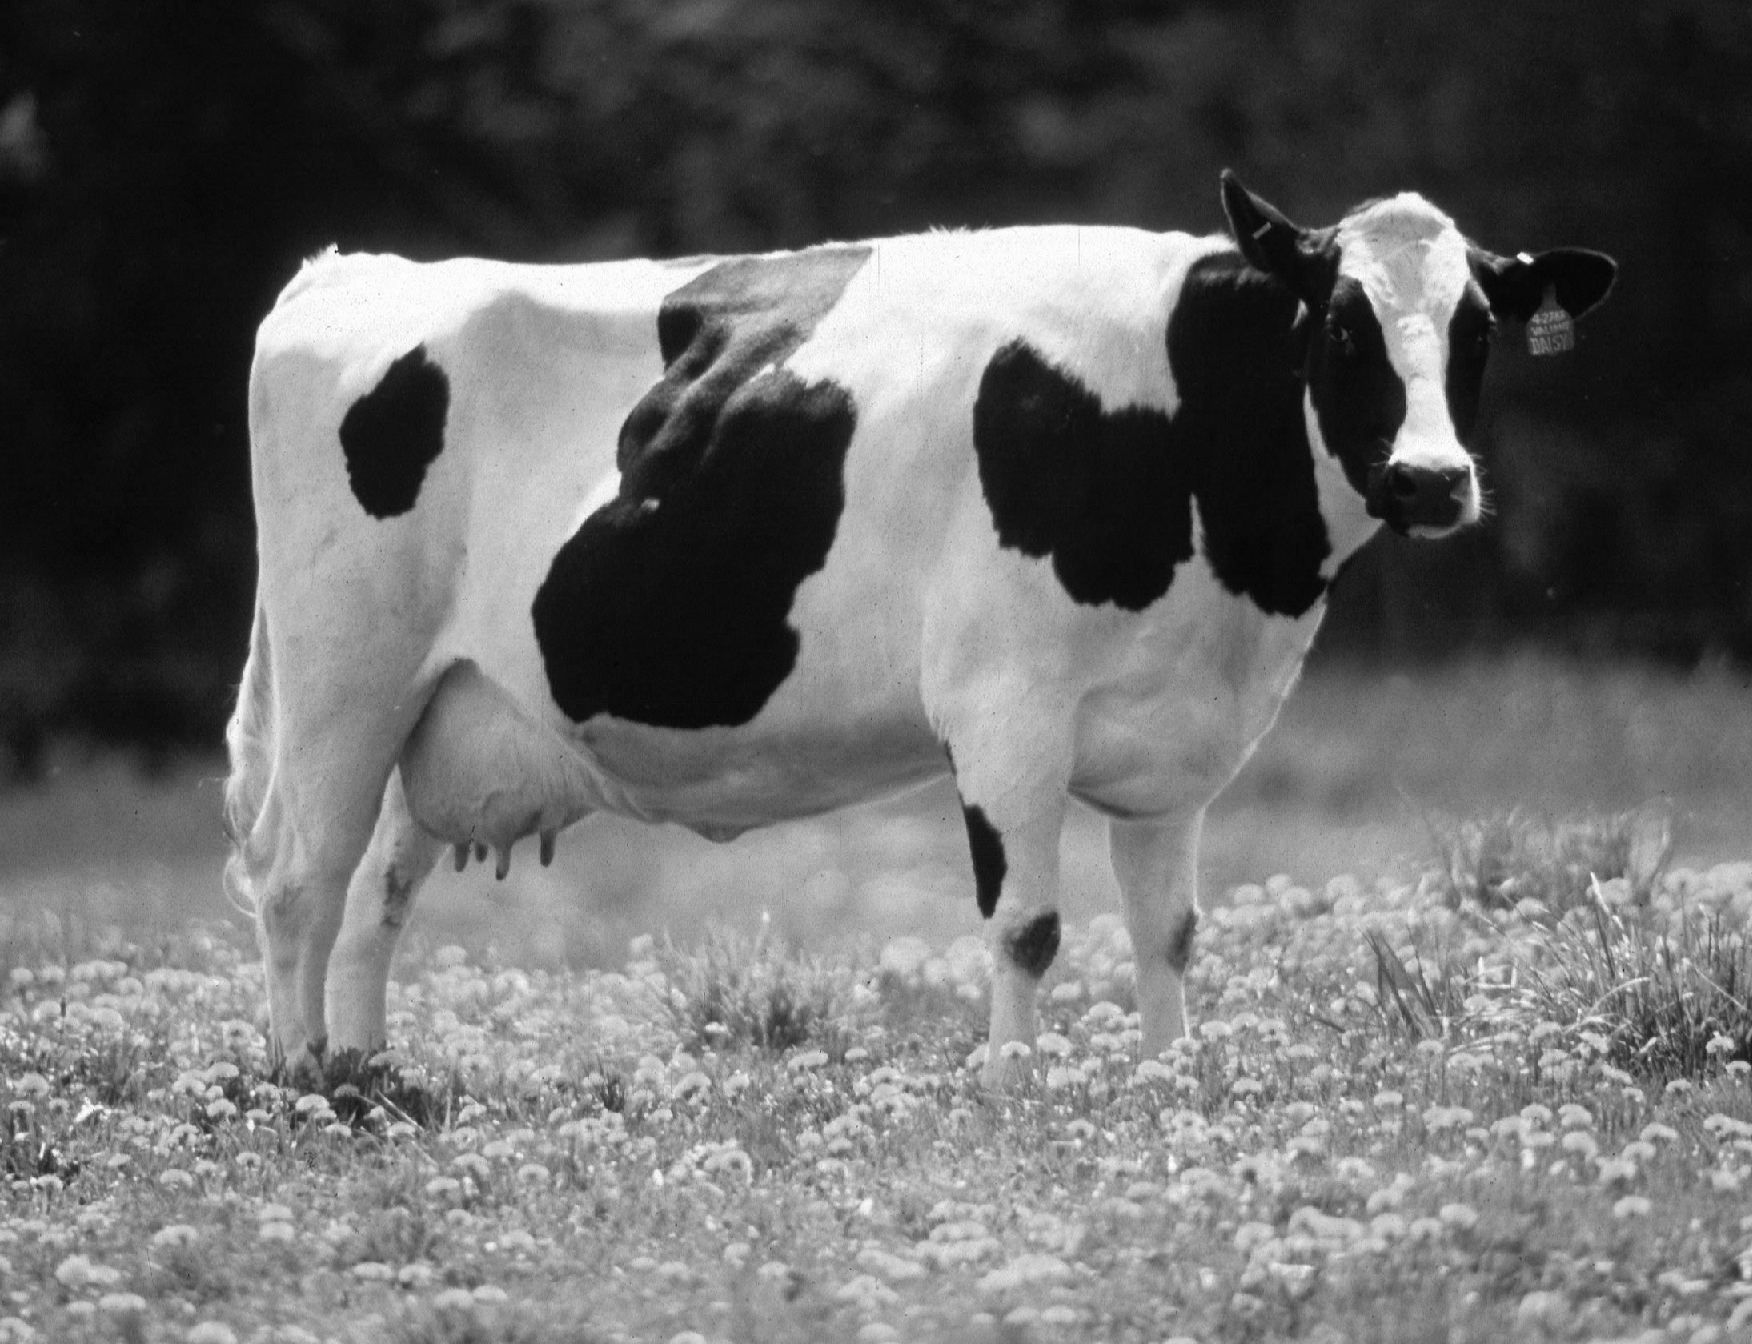

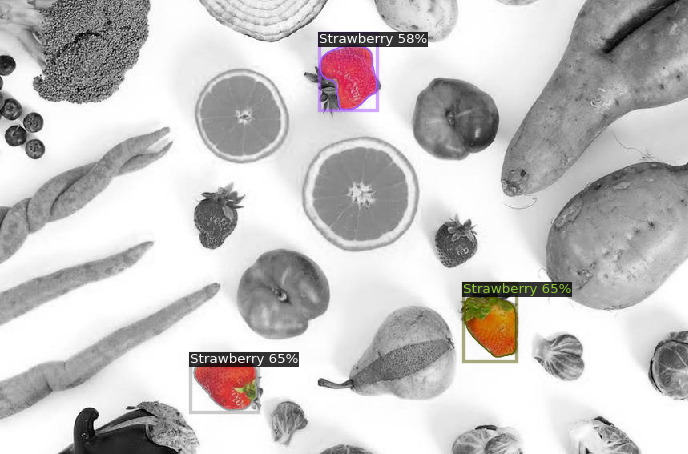

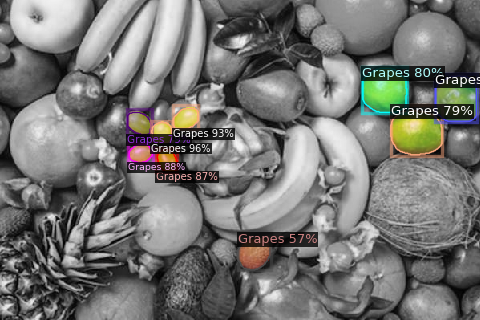

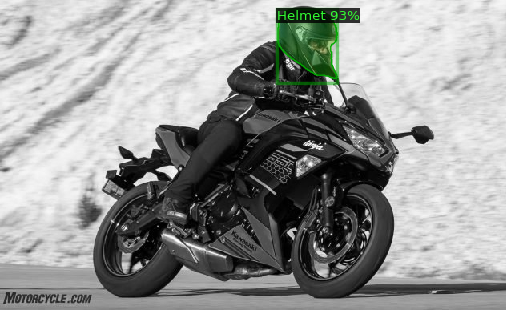

In [17]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(dataset_dicts, 4):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=sample_metadata,
                   scale=0.8,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

# Evaluation

In [18]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("sample", output_dir= "./output")
val_loader = build_detection_test_loader(cfg, "sample")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

WARNING [12/14 17:43:18 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[12/14 17:43:18 d2.data.datasets.coco]: Loaded 51 images in COCO format from ./data/trainval.json
[12/14 17:43:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/14 17:43:18 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/14 17:43:18 d2.data.common]: Serializing 51 elements to byte tensors and concatenating them all ...
[12/14 17:43:18 d2.data.common]: Serialized dataset takes 0.13 MiB
[12/14 17:43:18 d2.evaluation.evaluator]: Start inference on 51 batches
[12/14 17:43:19 d2.evaluation.evaluator]: Inference done 11/51. Dataloading: 0.0018 s/iter. Inference: 0.1201 s/iter. Eval: 0.0026 s/iter. Total: 0.1245 s/iter. ETA=0:00:04
[12/14 17:43:25 d2.evaluation.evaluator]: Inference

## Getting the custom config file

In [19]:
pwd

'/content/drive/MyDrive/Deep_Learning'

In [20]:
f = open('config.yml', 'w')
f.write(cfg.dump())
f.close()